# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [ ]:
!pip install jsonlines
import os
import json
import jsonlines
import numpy as np
from tqdm import tqdm, notebook
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/2020.1011/HW/HW2/Answer/answer-part2/

/content/drive/.shortcut-targets-by-id/1lw8YIdTE5p10TT6vMJ--f5lc1ycU0hJv/2020.1011/HW/HW2/Answer/answer-part2


---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data & Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [ ]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

datasets,vocab = load_wikitext()

--2020-12-04 01:22:06--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.24.197
Connecting to nyu.box.com (nyu.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-12-04 01:22:06--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-12-04 01:22:06--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.24.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/

In [ ]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
        # include test
        for line in tqdm(datasets['test']):
            for w in line:
                self.add_token(w)
        
        
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [ ]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [ ]:
with open('wikitext_dict.pickle', 'rb') as handle:
    wikitext_dict = pickle.load(handle)

# checking some example
print(' '.join(datasets['train'][231]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][231])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

26 laborers in the ammunition laboratory , and a carpenter for making packing boxes .

 encoded - [1580, 1574, 33, 6, 1128, 1463, 10, 30, 20, 1581, 98, 96, 1582, 1583, 39]

 decoded - ['26', 'laborers', 'in', 'the', 'ammunition', 'laboratory', ',', 'and', 'a', 'carpenter', 'for', 'making', 'packing', 'boxes', '.']


In [ ]:
## tokenize the dataset given a dictionary 
from torch.utils.data import Dataset, DataLoader
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

## generate the input and target
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []

        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))  ## input tensor list. 
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))  ## output tensor list
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])


In [ ]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)  ## tokenize dataset to numbers
wikitext_tensor_dataset = {}  

for split, listoflists in wikitext_tokenized_datasets.items():  
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)  
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 148361.12it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])   ## get the max length
    padded_list = []
    
    for t in list_of_tensors:  
        ## concatenate each sample with pad_tokens
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)  
        
    padded_tensor = torch.cat(padded_list, dim=0)  
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]   ## get inputs in the batch
    target_list = [s[1] for s in batch]  ## get the target in the batch
    
    pad_token = wikitext_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor 

In [ ]:
wikitext_loaders = {}

batch_size = 64

for split, wikitext_dataset in wikitext_tensor_dataset.items():  ## split(train, valid and test)
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [ ]:
next(iter(wikitext_loaders['train']))

(tensor([[    0,    75,  2160,  ...,     2,     2,     2],
         [    0, 16522,     6,  ...,     2,     2,     2],
         [    0,    75, 22515,  ...,     2,     2,     2],
         ...,
         [    0,   130,  3576,  ...,     2,     2,     2],
         [    0, 23706,    10,  ...,     2,     2,     2],
         [    0,    75,  1056,  ...,     2,     2,     2]]),
 tensor([[   75,  2160,   645,  ...,     2,     2,     2],
         [16522,     6, 15938,  ...,     2,     2,     2],
         [   75, 22515,   115,  ...,     2,     2,     2],
         ...,
         [  130,  3576,    10,  ...,     2,     2,     2],
         [23706,    10,   234,  ...,     2,     2,     2],
         [   75,  1056,   457,  ...,     2,     2,     2]]))

#### Model + Training (5 pts)

In [ ]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True

In [ ]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> output, (h_n,c_n)     (hidden,hidden*num_layers)
        output, (h_n, c_n) = self.lstm(embeddings)
        logits = self.projection(output)
        
        return logits

In [ ]:
if load_pretrained == True:
    hidden_size = 512
    embedding_size = 256
    model_dict = torch.load("model.pt")
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict["state_dict"])
else:
    options = {
        'num_embeddings': len(wikitext_dict),
        'embedding_dim': 256,
        'padding_idx': wikitext_dict.get_id('<pad>'),
        'input_size': 256,
        'hidden_size': 512,
        'num_layers': 3,
        'lstm_dropout': 0.1,
      }
    model = LSTMLanguageModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters)

    plot_cache = {"train":[], "valid":[]}

    PATIENCE = 3
    PATIENCE_COUNT = 0
    best_val_loss = 1e6

    for epoch in notebook.tqdm(range(5), desc='Epoch'):
        # do train
        train_log_cache = []
        model.train()
  
        epoch_iterator = notebook.tqdm(wikitext_loaders['train'], desc='Iteration')
        for i, (inp, target) in enumerate(epoch_iterator):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())

        avg_loss = sum(train_log_cache) / len(train_log_cache)
        print("epoch {} training loss: {}".format(epoch, avg_loss))
        plot_cache["train"].append(avg_loss)
        
        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(wikitext_loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                
                valid_losses.append(loss.item())
            
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('epoch {} validation loss: {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))
            
        plot_cache["valid"].append(avg_val_loss)

        # early stopping implementation
        if avg_val_loss < best_val_loss: # improvement
          PATIENCE_COUNT = 0  # reset the counter
          best_val_loss = avg_val_loss
          torch.save(
              {
              "state_dict": model.state_dict(),   
                "plot": plot_cache,
                "options": options
              }
              , "model.pt"
          )
        else: # no improvement
          PATIENCE_COUNT += 1
          print("have not improved in {} epoch(s)".format(PATIENCE_COUNT))
          if PATIENCE_COUNT == PATIENCE:
            print("max patience reached")
            break

#### Performance variation based on hyper-parameter values (5 pts)

In [ ]:
def plot_train_val_loss(model):
    plot_cache = model_dict['plot']
    epochs = np.array(list(range(len(plot_cache['train']))))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, plot_cache['train'], label='Train loss')
    plt.plot(epochs, plot_cache['valid'], label='Valid_loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Training and Validation Loss (hidden_dim = 512, embedding_size = 256)")
    plt.legend()
    plt.show()

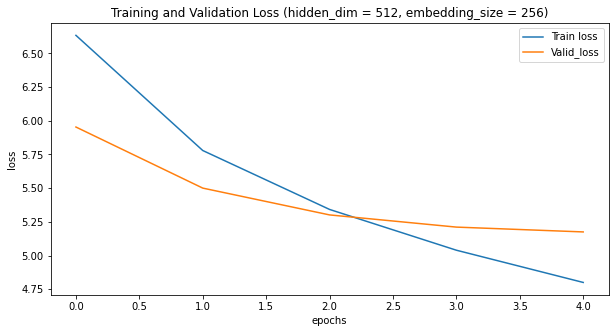

In [ ]:
plot_train_val_loss(model)

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.

#### 2.1 Word similarity (3 pts)

In [ ]:
def cosine_similarity(x1, x2, dim=0, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

In [ ]:
def find_neighbors(model, number_neighbors, word_list):
    closest_dict_projection = {}
    farthest_dict_projection = {}

    lsts_projection = {}
    weight_matrix_projection = model.projection.weight

    for word in word_list:
        lst_projection = []
        word_id = wikitext_dict.get_id(word)
        for i in notebook.tqdm(range(weight_matrix_projection.size(0))):
            if i not in [wikitext_dict.get_id("<unk>"), wikitext_dict.get_id("<pad>"), word_id]:
                cos_sim = cosine_similarity(weight_matrix_projection[word_id],weight_matrix_projection[i])
                lst_projection.append((cos_sim.item(), i))
            lst_projection = sorted(lst_projection, key=lambda x: x[0], reverse=True)
            lsts_projection[word] = lst_projection
            closest_dict_projection[word] = [l[1] for l in lst_projection[:number_neighbors]]
            farthest_dict_projection[word] = [l[1] for l in lst_projection[-number_neighbors:]]
    return closest_dict_projection, farthest_dict_projection, lsts_projection

In [ ]:
word_list = ['the', 'good', 'bad', 'where', 'fun']

closest, farthest, all = find_neighbors(model, 10, word_list)

In [ ]:
closest

{'bad': [14980, 14982, 483, 4879, 25192, 5305, 5351, 10505, 855, 8941],
 'fun': [8502, 19351, 7745, 13041, 15773, 9234, 8575, 14467, 2151, 15777],
 'good': [470, 885, 4441, 304, 1522, 4233, 5155, 1312, 6242, 2481],
 'the': [20, 345, 135, 46, 280, 460, 349, 105, 232, 438],
 'where': [396, 150, 207, 65, 1619, 309, 2504, 110, 5014, 25233]}

In [ ]:
for word in word_list:
  print('Word: ' + word +'\n')
  print("The closest 10 words are", ":", [wikitext_dict.get_token(i) for i in closest[word]])
  print("The farthest 10 words are", ":",[wikitext_dict.get_token(i) for i in farthest[word]])
  close = wikitext_dict.get_token(all[word][0][1])
  far = wikitext_dict.get_token(all[word][-1][1])
  print("The highest cosine similarity is %f, the similarity between %s and %s" %(all[word][0][0], word, close))
  print("The lowest cosine similarity is %f, the similarity between %s and %s" %(all[word][-1][0], word, far))
  print('-'*150)

Word: the

The closest 10 words are : ['a', 'his', 'an', 'its', 'their', 'this', 'her', 'both', 'some', 'these']
The farthest 10 words are : ['Nene', 'Book', 'Cathedral', 'Tribunal', 'repertoire', 'Institute', 'Preparations', 'interchange', 'Press', 'Trophy']
The highest cosine similarity is 0.605633, the similarity between the and a
The lowest cosine similarity is -0.392587, the similarity between the and Trophy
------------------------------------------------------------------------------------------------------------------------------------------------------
Word: good

The closest 10 words are : ['great', 'serious', 'superior', 'unique', 'strong', 'happy', 'false', 'safe', 'effective', 'dark']
The farthest 10 words are : ['The', 'is', '=', ';', 'A', '–', 'was', '(', 'and', ',']
The highest cosine similarity is 0.684519, the similarity between good and great
The lowest cosine similarity is -0.283271, the similarity between good and ,
-------------------------------------------------

#### 2.2 UMAP (3 pts)

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
!pip install umap-learn

In [ ]:
word_list_id = [wikitext_dict.get_id(word) for word in word_list]
word_list_id

[6, 894, 6882, 163, 3538]

In [ ]:
%pylab inline 
import umap

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001, low_memory=True).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(15,15))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split', 'close']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
total_idx_projection = [closest[w] for w in word_list] + [farthest[w] for w in word_list]
import itertools
total_idx_projection = list(itertools.chain(*total_idx_projection))
total_words_projection = word_list + [wikitext_dict.get_token(i) for i in total_idx_projection]
total_idx_projection = [wikitext_dict.get_id(w) for w in word_list] + total_idx_projection

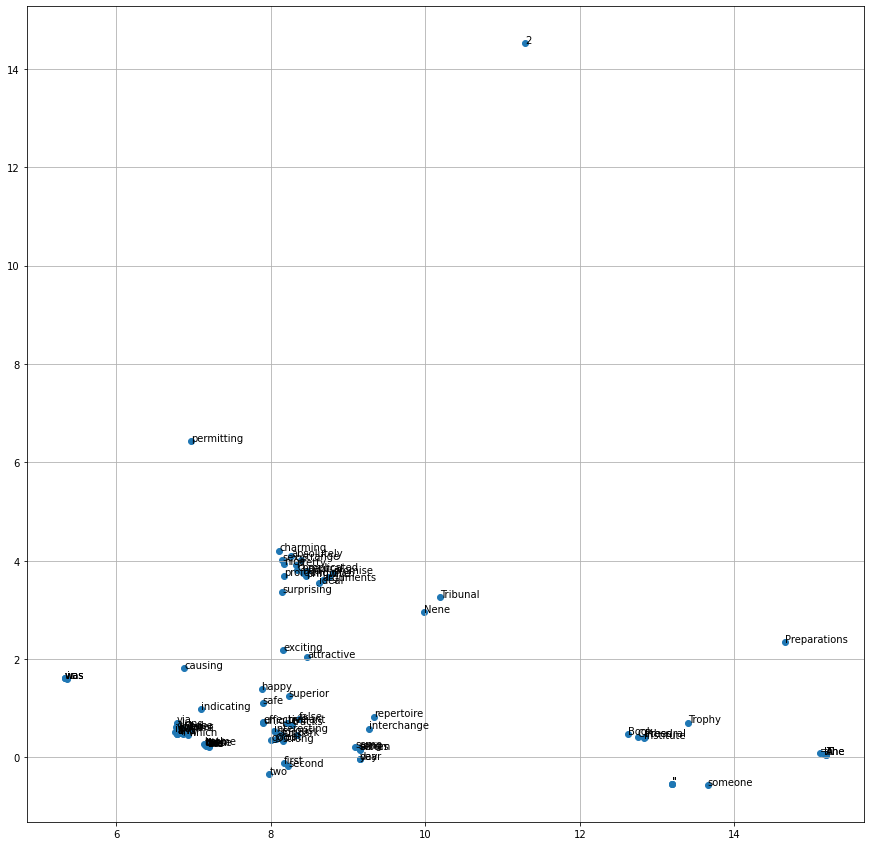

In [ ]:
weight_matrix_projection = model.projection.weight
umap_plot(weight_matrix_projection, total_idx_projection, total_words_projection)

---
### 3 Sampling (14 pts)


In [ ]:
import random
ids = random.sample(range(len(wikitext_tensor_dataset["valid"])), 1000)
samples_val = []
wikitext_tokenized_datasets["valid"][0]

for i in ids:
  sent = wikitext_tokenized_datasets["valid"][i]
  sent = [wikitext_dict.get_token(idx) for idx in sent]
  samples_val.append(" ".join(sent))

#### 3.1 Sampling implementation (4 pts)
For the sampling implementation, we have 2 solutions:
- Following the pseudo-code, we are feeding into the model one token at a time, so we will have to break the model into 3 layers and manually feed the hidden state $h_{t-1}$ to the LSTM at each time-step. The reason here is that, to generate a new token $x_t$, we need to sample from probability distribution $P(x_t|x_{<t}) = \text{softmax}(\text{projection}(h_t))$. However, $h_t = f(x_t,h_{t-1})$ is a function of both the current token $x_t$ and the previous hidden state $h_{t-1}$, which encodes information from all previous tokens $x_{<t}$. Thus, in the implementation we have to make the LSTM layer return the hidden states as we will feed them back into the LSTM at the next time-step. Because the way our model forward method is set up, $\text{model}(x_t)$ returns the logits for $P(x_{t+1}|x_{t})$, instead of $P(x_{t+1}|x_{<t})$. This is a very important distinction to notice.
- Alternatively, if we insist on using the model forward method instead of breaking the model into 3 layers, we can simply forward all previous tokens together at each time-step: $\text{softmax}(\text{model}(x_1,...,x_{t-1})) = P(x_t|x_{<t}).$


**solution 1: following the pseudo-code**

In [ ]:
samples = []
for i in notebook.tqdm(range(1000)):
    start_index = torch.tensor([wikitext_dict.get_id("<bos>")]).view(1,-1)
    inp = start_index
    sample = ["<bos>"]
    model.eval()
    h_t = torch.zeros(options["num_layers"], 1, options["hidden_size"]).to(current_device)
    c_t = torch.zeros(options["num_layers"], 1, options["hidden_size"]).to(current_device)
    while inp.item() != wikitext_dict.get_id("<eos>"):
        out = model.lookup(inp.to(current_device))
        out = out.view(1, 1, -1)
        out, (h_t, c_t) = model.lstm(out, (h_t, c_t))
        out = model.projection(out)
        prob_distr = torch.softmax(out[0, -1], dim=-1)
        sample_id = torch.multinomial(prob_distr, 1).item()
        sample_token = wikitext_dict.get_token(sample_id)
        sample.append(sample_token)
        inp = torch.tensor([wikitext_dict.get_id(sample_token)])
    samples.append(" ".join(sample))

**solution 2: alternative solution**

In [ ]:
samples2 = []
for i in notebook.tqdm(range(1000)):
  sample = ["<bos>"]
  while sample[-1] != "<eos>":
    inp = wikitext_dict.encode_token_seq(sample)
    model.eval()
    logits = model(torch.tensor([inp], dtype=torch.long).to(current_device)).to(current_device)
    prob_distr = torch.softmax(logits[0, -1], dim=-1)
    sample_id = torch.multinomial(prob_distr, 1)
    word = wikitext_dict.get_token(sample_id)
    sample.append(word)
  samples2.append(" ".join(sample))

In [ ]:
samples[-10:]

['<bos> The Wolfpack of only a presbyterian ruler through the common size was <unk> ( <unk> III ) , they < <eos>',
 '<bos> Earlier on St Nazaire , not a wide amount farcical centered line . <eos>',
 '<bos> The genus continues from a so Isesi noticed to create the name creature at < <eos>',
 '<bos> In 1962 to 9 @,@ 1965 at the bottom of this time B Cove became established in Canada . <eos>',
 '<bos> Language theorists , a single review of the crown erected . <eos>',
 '<bos> Director Eliot grew # 10 as the Australian book in 1994 – 2008 . <eos>',
 "<bos> In the DAG of Baltimore 's tenure , Splitsider began his article novel and appealed that he was moved to favor by his words : <eos>",
 "<bos> Star Charles , Churchill of GameSpot 's Simpson session , was found , but Upon he sleeps . <eos>",
 '<bos> In 2009 Mosley agreed to showcase Poesy Ross and soldiers as " crumbling their concern with Taylor who reminds fans for the Planet of Physics , hip @-@ eyed nature of James Ball , Grace , the 

In [ ]:
samples2[-10:]

['<bos> With World <unk> ( <unk> $ <unk> ° F ) for 4 @,@ <unk> gun that would migrate more concrete , it was heavier , with 2 @,@ 020 <unk> and <eos>',
 '<bos> Despite as he had only been rebuilt on the <unk> in Theodore <unk> . <eos>',
 '<bos> 354 originally praised the land in some languages lie , and he <unk> by Caged to hold between 1 and in enormous occasions . <eos>',
 '<bos> It does not Jamaica the pipes , including searching that remain highly vibrant sluggish . <eos>',
 '<bos> <unk> , also <unk> from the city , restored in Assyrian water . <eos>',
 '<bos> In Connecticut , <unk> rejected of Little Area Department drew 39 in the year – <unk> <eos>',
 '<bos> In <unk> <unk> , the <unk> <unk> formed the Irish community <eos>',
 '<bos> You guess involved 240 that a band is contemplating a really surgeon ... <eos>',
 '<bos> unk> , and <unk> , the daughter Howard Henry " , which were decided for representatives of the church when he told the label . <eos>',
 '<bos> The concept is a po

#### 3.2 1,000 samples and average log probability implementation (4 pts)
To understand how to calculate the log probability of a sequence $(x_1,x_2,...,x_T),$ we need to first notice that because we have an autoregressive language model, we have $$\log P(x_1,...,x_T) = \log\prod_{t=1}^{T}P(x_t|x_{<t}) = \sum_{t=1}^{T}\log P(x_t|x_{<t}).$$ However, recall from last question that $P(x_t|x_{<t})$ is just the output of the model at each time-step after having applied a softmax. Thus, to calculate $\log P(x_1,...,x_T)$, we need to go to each time-step and access this probability distribution and get the index that we care about, and then sum them up together.

In [ ]:
def get_prob_of_sequence(seq, token="<eos>"):
    inp = wikitext_dict.encode_token_seq(seq.split(' '))
    target = inp[1:] + [wikitext_dict.get_id(token)] # shift by 1 index
    
    with torch.no_grad():
        model.eval()
        logits = model(torch.tensor([inp], dtype=torch.long).to(current_device))

    T = len(inp)
    ans = 0
    for i in range(T):
        tokid = target[i]
        prob_distr = torch.softmax(logits[0, i], dim=-1)
        prob_distr = prob_distr.cpu()
        ans += np.log(prob_distr[tokid]).item()
    return ans

seq = "<bos> i have a cat"
get_prob_of_sequence(seq)

-41.09731411933899

#### 3.3 Number of unique tokens and sequence length (3 pts)

In [ ]:
set_sample = set()
set_sample_val = set()
len_sample = []
len_sample_val = []

for i in range(len(samples)):
  sent = samples[i].split(" ")
  len_sample.append(len(sent))
  for word in sent:
    set_sample.add(word)
  
for i in range(len(samples_val)):
  sent = samples_val[i].split(" ")
  len_sample_val.append(len(sent))
  for word in sent:
    set_sample_val.add(word)

    
print("unique tokens in random samples:",len(set_sample))
print("average sentence length in random samples:",float(sum(len_sample)/len(len_sample)))
print("unique tokens in validation set:",len(set_sample_val))
print("average sentence length in validation set:",float(sum(len_sample_val)/len(len_sample_val)))

  

unique tokens in random samples: 6158
average sentence length in random samples: 25.444
unique tokens in validation set: 4927
average sentence length in validation set: 24.942


get average log score across 1000 sequences

In [ ]:
avg = 0.0
for sample in notebook.tqdm(samples):
  avg += get_prob_of_sequence(sample)
print(avg / len(samples))


-122.4394703117587


#### 3.4 Example samples (3 pts)

In [ ]:
ids = random.sample(range(len(samples)), 3)
for i in ids:
  print(samples[i])

<bos> Even traveling , the new assault from removing the Old Vic labour as <unk> , <unk> , and Scheer , and named Tiberias , halted in Red affairs . <eos>
<bos> Born in the meantime was reported by the Fine Fork at Hubbardton in 1669 , the highway feel that a new design had part of the royal archaeologist <unk> <eos>
<bos> Spring National Historic Etingoff ( au emphasis ) was built in Super Lanka , 44 @-@ elite with Scottish Vallarta ) <eos>


The samples look machine-generated because they are gramatically not correct. Also, they do not staty on topic, though some terms make logical sense.